In [1]:
%cd ..

/Users/pablomirallesgonzalez/Documents/masters-degree/Análisis de Redes Sociales/sna-ceb-assignment


In [150]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from networkx import community as nxcom
from cdlib.algorithms import leiden
from sklearn.metrics import normalized_mutual_info_score

In [33]:
# aux functions to get color in hex format
colormap = plt.cm.get_cmap('tab20')
rescale = lambda val: int(val * 255)
get_color_str = lambda x: "#{:02x}{:02x}{:02x}{:02x}".format(*map(rescale, colormap(x)))

In [105]:
def community_list_to_dict(communities: list[list[int]]) -> dict[int, int]:
    # list of list of nodes in the same community to dict of node to community
    return {
        node: ind
        for ind, community in enumerate(communities)
        for node in community
    }

def community_dict_to_list(community_dict: dict[int, int]) -> list[list[int]]:
    # dict of node to community to list of list of nodes in the same community
    num_communities = max(community_dict.values()) + 1
    communities = [[] for _ in range(num_communities)]
    for node, community in community_dict.items():
        communities[community].append(node)
    return communities

## Carga de datos

In [3]:
GRAPH_FILE = "data/amazon_graph.graphml"
graph = nx.read_graphml(GRAPH_FILE)

In [4]:
graph.number_of_nodes(), graph.number_of_edges()

(475, 1184)

## Algoritmo de Leiden

### Obtención de comunidades y de modularidad

In [139]:
# WARNING: I haven't been able to make this deterministic
leiden_communities = leiden(graph).communities

In [140]:
modularity = nxcom.modularity(graph, leiden_communities)
num_communities = len(leiden_communities)
print(f"Modularity: {modularity:.4f}")
print(f"Number of communities: {num_communities}")

Modularity: 0.8824
Number of communities: 19


### Visualización

Veamos algunas visualizaciones comparativas entre las comunidades obtenidas y las originales del *dataset*.

Text(0.5, 1.0, 'Original')

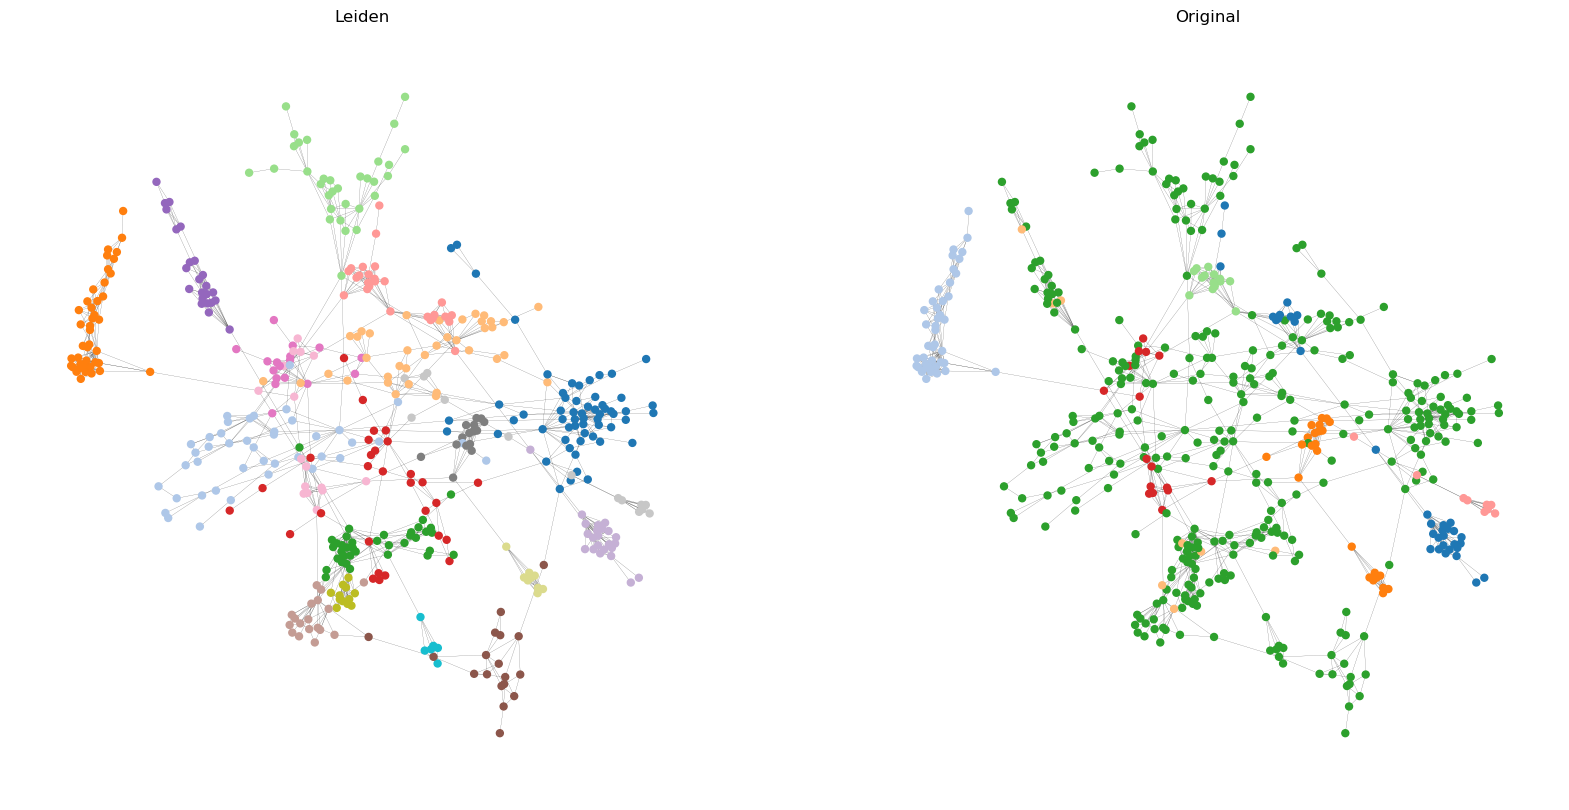

In [141]:
pos = nx.spring_layout(graph, seed=42)

# two plots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

node_to_community = community_list_to_dict(leiden_communities)
colors_leiden = [get_color_str(node_to_community[node]) for node in graph.nodes()]
nx.draw(graph, pos=pos, node_color=colors_leiden, node_size=25, width=0.1, with_labels=False, ax=ax1)

colors_orig = [get_color_str(attr["community"]) for node, attr in list(graph.nodes(data=True))]
nx.draw(graph, pos=pos, node_color=colors_orig, node_size=25, width=0.1, with_labels=False, ax=ax2)

ax1.set_title("Leiden")
ax2.set_title("Original")

Vemos que en las comunidades originales hay una muy grande (verde) que se ha dividido en muchas. Esto podría deberse al problema de resolución visto en clase, aunque esperaría el comportamiento contrario: juntar comunidades pequeñas en otras más grandes.

In [142]:
def plot_circular_community_graph(
    graph: nx.Graph,
    communities: list[list[int]],
    node_scale: float = 40.,
    edge_scale: float = 0.33,
    ax=None,
):
    communities.sort(key=len, reverse=True)
    node_to_community = community_list_to_dict(communities)

    # Create a new graph
    community_graph = nx.Graph()

    # Add nodes for each community
    for ind, community in enumerate(communities):
        community_graph.add_node(ind, size=len(community), color=get_color_str(ind))

    # Add edges between communities
    for node1, node2 in graph.edges():
        community1 = node_to_community[node1]
        community2 = node_to_community[node2]
        if community1 == community2:
            continue
        if community_graph.has_edge(community1, community2):
            community_graph[community1][community2]['weight'] += 1
        else:
            community_graph.add_edge(community1, community2, weight=1)

    # Set node sizes and colors
    node_sizes = [community_graph.nodes[node]['size'] * node_scale for node in community_graph.nodes()]
    node_colors = [community_graph.nodes[node]['color'] for node in community_graph.nodes()]

    # Set edge weights
    edge_weights = [community_graph.edges[edge]['weight'] * edge_scale for edge in community_graph.edges()]

    # Plot the graph
    pos = nx.circular_layout(community_graph)
    nx.draw(
        community_graph,
        pos=pos,
        node_size=node_sizes,
        node_color=node_colors,
        width=edge_weights,
        with_labels=True,
        ax=ax,
    )


Text(0.5, 1.0, 'Original - Community Graph')

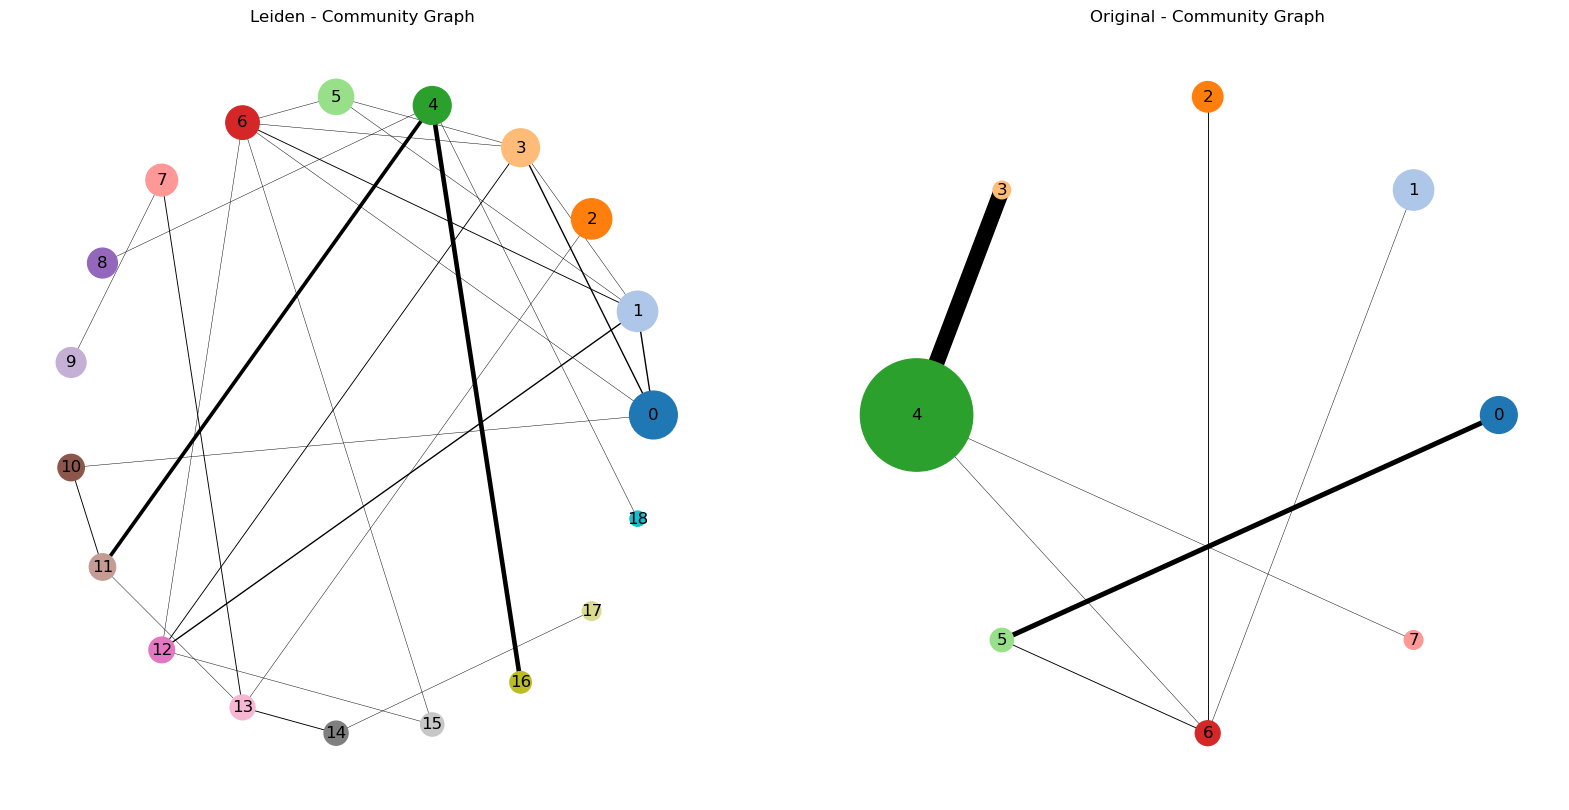

In [148]:
# two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_circular_community_graph(graph, communities=leiden_communities, node_scale=20., ax=ax1)
plot_circular_community_graph(graph, communities=community_dict_to_list({node: attr["community"] for node, attr in list(graph.nodes(data=True))}), node_scale=20., ax=ax2)

ax1.set_title("Leiden - Community Graph")
ax2.set_title("Original - Community Graph")

In [146]:
def plot_bipartite_community_graph(
    graph: nx.Graph,
    communities_1: list[list[int]],
    communities_2: list[list[int]],
    node_scale: float = 40.,
    edge_scale: float = 0.33,
    ax=None,
):
    node_to_community_1 = community_list_to_dict(communities_1)
    node_to_community_2 = community_list_to_dict(communities_2)

    # Create a new graph
    bipartite_community_graph = nx.Graph()

    # Add nodes for each community
    for ind, community in enumerate(communities_1):
        bipartite_community_graph.add_node(ind, size=len(community), color=get_color_str(1))
    for ind, community in enumerate(communities_2, start=len(communities_1)):
        bipartite_community_graph.add_node(ind, size=len(community), color=get_color_str(2))

    # Add edges between communities
    for node in graph.nodes():
        community_1 = node_to_community_1[node]
        community_2 = node_to_community_2[node] + len(communities_1)

        if bipartite_community_graph.has_edge(community_1, community_2):
            bipartite_community_graph[community_1][community_2]['weight'] += 1
        else:
            bipartite_community_graph.add_edge(community_1, community_2, weight=1)


    # Set node sizes and colors
    node_sizes = [bipartite_community_graph.nodes[node]['size'] * node_scale for node in bipartite_community_graph.nodes()]
    node_colors = [bipartite_community_graph.nodes[node]['color'] for node in bipartite_community_graph.nodes()]

    # Set edge weights
    edge_weights = [bipartite_community_graph.edges[edge]['weight'] * edge_scale for edge in bipartite_community_graph.edges()]

    # Plot the graph
    pos = nx.bipartite_layout(
        bipartite_community_graph,
        [node for node in bipartite_community_graph.nodes() if node < len(communities_1)]
    )
    nx.draw(
        bipartite_community_graph,
        pos=pos,
        node_size=node_sizes,
        node_color=node_colors,
        width=edge_weights,
        with_labels=True,
        ax=ax,
    )

Text(0.5, 1.0, 'Leiden (left) intersection with Original (right)')

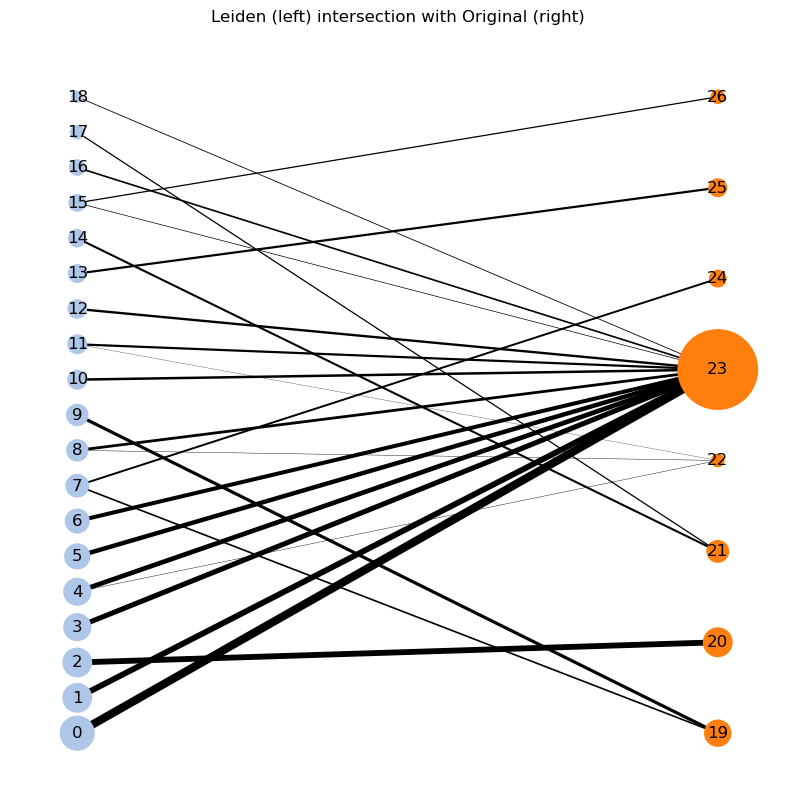

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_bipartite_community_graph(
    graph,
    communities_1=leiden_communities,
    communities_2=community_dict_to_list({node: attr["community"] for node, attr in list(graph.nodes(data=True))}),
    node_scale=10.,
    edge_scale=0.1,
    ax=ax,
)

ax.set_title("Leiden (left) intersection with Original (right)")

Vemos que efectivamente la comunidad grande se ha dividido en muchas, y el resto están más o menos parejas (aunque no del todo).

### Comparación con las comunidades preestablecidas
Además de las visualizaciones, podemos usar la métrica *normalized mutual information* para medir más objetivamente el parecido entre las comunidades detectadas.

In [151]:
# Convert the communities to lists of labels
original_communities = [attr["community"] for _, attr in list(graph.nodes(data=True))]
leiden_communities = [node_to_community[node] for node in graph.nodes()]

# Calculate the normalized mutual information
nmi = normalized_mutual_info_score(original_communities, leiden_communities)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.5349


Teniendo en cuenta que el valor está entre $0$ y $1$, está por la mitad. Son, por lo tanto, bastante distintas.